In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier # for traning
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict # for cross validation
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler # for scaling inputs
from sklearn.neighbors import KNeighborsClassifier
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
mnist = fetch_mldata('MNIST original')

In [4]:
X,y=mnist['data'],mnist['target']
print X.shape
print y.shape 
print y


(70000, 784)
(70000,)
[ 0.  0.  0. ...,  9.  9.  9.]


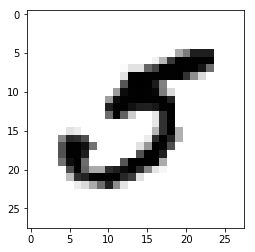

5.0


In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = matplotlib.cm.binary,interpolation= 'nearest')
plt.show()
print y[36000]

In [6]:
# splitting traning and test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffling 
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [7]:
# traning a binary classifier

y_train_5 = (y_train == 5) # true for all 5 else 0
y_test_5 = (y_test == 5)

In [8]:
# picking a classifier 
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [9]:
# predicting 
out = sgd_clf.predict([some_digit])
print out

[ True]


In [10]:
# Cross Validation

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index,test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold  = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print n_correct*1.00000/len(y_pred)

0.96695
0.961
0.93125


In [11]:
cross_val_score(sgd_clf,X_train,y_train_5, cv=3, scoring='accuracy')

array([ 0.96695,  0.961  ,  0.93125])

In [12]:
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9077 ,  0.91145,  0.9098 ])

In [14]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv =3)
print y_train_pred

[False  True False ..., False False False]


In [15]:
# confusion matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52680,  1899],
       [  917,  4504]])

In [16]:
# Predcision and recall

print precision_score(y_train_5, y_train_pred)
print recall_score(y_train_5, y_train_pred)

0.703420271748
0.830843017893


In [17]:
#f1_score
f1_score(y_train_5, y_train_pred)

0.76184032476319363

In [18]:
# decision_function so that we can set threshold

y_scores = sgd_clf.decision_function([some_digit])
print y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print y_some_digit_pred


[ 96959.69560769]
[ True]


In [19]:
threshold =200000
y_some_digit_pred = (y_scores > threshold)
print y_some_digit_pred

[False]


In [20]:
#deciding threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
print y_scores

[-327831.89238996   83229.10791351 -717292.93448469 ..., -884915.29716857
 -187068.4919606  -507768.14718276]


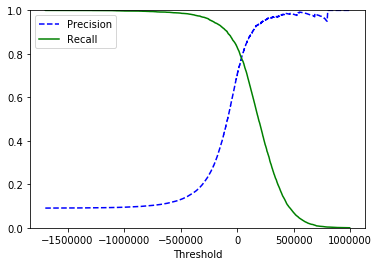

In [21]:
# precision recall curve

precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precision,recalls,thresholds):
    plt.plot(threshold, precision[:-1], 'b--', label='Precision')
    plt.plot(threshold,recalls[:-1], 'g-',label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, threshold)
plt.show()

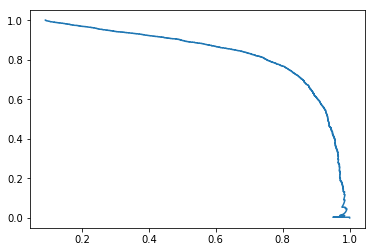

In [22]:
plt.plot(precisions,recalls)

In [23]:
#changing thresholds

threshold = 70000

y_train_pred_90 = (y_scores>threshold)

In [24]:
# checking new precison and recall score

print precision_score(y_train_5, y_train_pred_90)
print recall_score(y_train_5, y_train_pred_90)

0.832635106829
0.733259546209


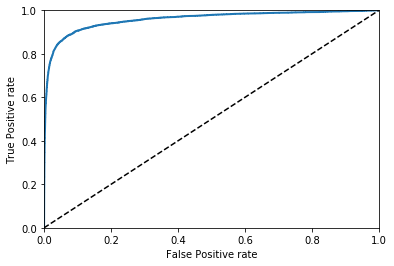

In [25]:
# roc curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive rate')
    plt.ylabel('True Positive rate')
plot_roc_curve(fpr,tpr)
plt.show()

In [26]:
# roc_auc_score
print roc_auc_score(y_train_5, y_scores)

0.958342910508


In [27]:
# using RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method='predict_proba')


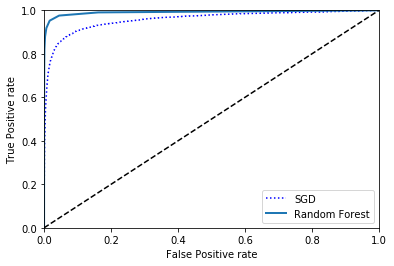

0.991456418602


In [28]:
# score= probabilities of positive class
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

print roc_auc_score(y_train_5, y_scores_forest)

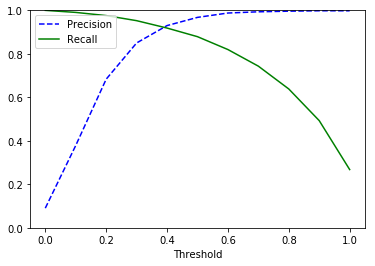

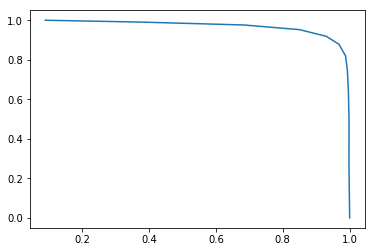

In [29]:
# precision recall curve

precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores_forest)

def plot_precision_recall_vs_threshold(precision,recalls,thresholds):
    plt.plot(threshold, precision[:-1], 'b--', label='Precision')
    plt.plot(threshold,recalls[:-1], 'g-',label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, threshold)
plt.show()

plt.plot(precisions,recalls)
plt.show()

In [30]:
# precision and recall of ForestClassifier
y_scores_forest_pred=(y_scores>70000)
print precision_score(y_train_5,y_scores_forest_pred)
print recall_score(y_train_5, y_scores_forest_pred)

0.832635106829
0.733259546209


In [31]:
# Multiclass Classificaton
# running SGDClassifier on whole y_train

sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])


array([ 5.])

In [32]:
some_digit_score= sgd_clf.decision_function([some_digit])
print some_digit_score

[[-159274.82778209 -318282.88600756 -138121.95321528  -32023.77445973
  -588501.15143417   96959.69560769 -663046.68282717 -217674.55694447
  -840915.27841426 -604453.00337336]]


In [33]:
print np.argmax(some_digit_score)


5


In [34]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print ovo_clf.predict([some_digit])
print len(ovo_clf.estimators_)

[ 5.]
45


In [35]:
#MultiClass RandomForestClassifier

forest_clf.fit(X_train, y_train)
print forest_clf.predict([some_digit])

[ 5.]


In [36]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0.1,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [37]:
# evluating classifer
cross_val_score(sgd_clf,X_train, y_train, cv=3, scoring='accuracy')

array([ 0.86087782,  0.87414371,  0.8673301 ])

In [38]:
# using scaled inputs for train

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print cross_val_score(sgd_clf, X_train_scaled, y_train,cv=3, scoring='accuracy')

[ 0.90796841  0.90974549  0.90968645]


[[5740    2   20    9   10   47   41    9   41    4]
 [   2 6461   47   24    6   47    8   11  122   14]
 [  57   39 5333   96   82   26   88   60  162   15]
 [  58   41  132 5318    2  251   35   57  139   98]
 [  19   27   33    8 5365   10   55   35   77  213]
 [  75   36   27  177   73 4617  114   27  178   97]
 [  39   26   42    2   47   86 5624    7   44    1]
 [  25   19   69   28   57   14    6 5816   16  215]
 [  54  156   72  140   14  172   53   26 5036  128]
 [  46   31   29   89  167   39    2  227   81 5238]]


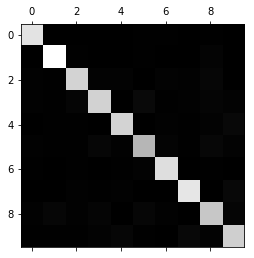

In [39]:
# error analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print conf_mx

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

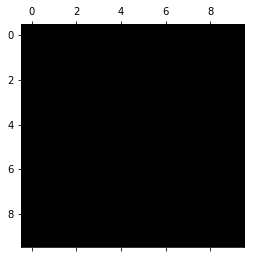

In [40]:
# error rates

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [41]:
#Multiclass Classification

y_train_large = (y_train >= 7)
y_train_odd= (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [42]:
print knn_clf.predict([some_digit])

[[False  True]]


In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)